In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [4]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round'])

In [5]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                 53
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


## Convert Categorical Variables to Numerical

In [6]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [7]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',
    'w_SvGms': 'p1_SvGms',
    'w_bpSaved': 'p1_bpSaved',
    'w_bpFaced': 'p1_bpFaced',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
    'l_SvGms': 'p2_SvGms',
    'l_bpSaved': 'p2_bpSaved',
    'l_bpFaced': 'p2_bpFaced'
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
1    8900
0    8647
Name: count, dtype: int64


In [8]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,185.0,25.6,1,188.0,30.6,123.0,9.0,2.0,...,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0,0
1,2,1,183.0,23.7,1,188.0,21.2,90.0,3.0,5.0,...,25.0,14.0,9.0,4.0,5.0,94.0,593.0,54.0,890.0,1
2,2,1,175.0,25.6,1,185.0,31.3,145.0,8.0,6.0,...,48.0,12.0,14.0,9.0,11.0,30.0,1391.0,63.0,809.0,1
3,2,1,183.0,18.8,1,188.0,28.0,104.0,9.0,3.0,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,1,188.0,19.9,0,193.0,27.2,69.0,5.0,4.0,...,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0,0


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,183.0,28.2,1,175.0,25.0,87.0,2.0,1.0,...,25.0,11.0,9.0,2.0,3.0,819.0,24.0,569.0,64.0,1
3066,2,1,178.0,31.0,1,188.0,28.8,65.0,4.0,2.0,...,17.0,9.0,8.0,2.0,5.0,279.0,205.0,900.0,18.0,0
3068,0,0,185.0,23.9,1,188.0,21.8,137.0,1.0,2.0,...,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0,0
3070,0,0,185.0,23.9,1,175.0,34.2,95.0,1.0,1.0,...,19.0,14.0,8.0,3.0,4.0,616.0,55.0,136.0,489.0,1
3074,2,1,185.0,27.3,1,175.0,26.9,159.0,5.0,3.0,...,41.0,13.0,14.0,2.0,5.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int32  
 1   p1_hand         17547 non-null  int32  
 2   p1_ht           17547 non-null  float64
 3   p1_age          17547 non-null  float64
 4   p2_hand         17547 non-null  int32  
 5   p2_ht           17547 non-null  float64
 6   p2_age          17547 non-null  float64
 7   minutes         17547 non-null  float64
 8   p1_ace          17547 non-null  float64
 9   p1_df           17547 non-null  float64
 10  p1_svpt         17547 non-null  float64
 11  p1_1stIn        17547 non-null  float64
 12  p1_1stWon       17547 non-null  float64
 13  p1_2ndWon       17547 non-null  float64
 14  p1_SvGms        17547 non-null  float64
 15  p1_bpSaved      17547 non-null  float64
 16  p1_bpFaced      17547 non-null  float64
 17  p2_ace          17547 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,0.861287,187.245227,27.161315,0.859976,187.212230,27.113769,115.207215,6.351798,2.952471,...,35.984328,15.489770,12.625349,4.091754,6.681085,79.081609,1533.252351,79.949678,1524.083034,0.507209
std,0.893933,0.345657,7.033034,4.571855,0.347022,7.159186,4.572776,42.268962,5.493804,2.463877,...,14.150344,6.843594,4.216331,3.226669,4.412784,107.768773,1735.309374,108.435735,1712.945352,0.499962
min,0.000000,0.000000,15.000000,16.400000,0.000000,15.000000,16.700000,5.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,83.000000,2.000000,1.000000,...,26.000000,11.000000,10.000000,2.000000,3.000000,26.000000,652.000000,25.000000,638.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.700000,108.000000,5.000000,2.000000,...,34.000000,14.000000,12.000000,4.000000,6.000000,55.000000,955.000000,56.000000,940.000000,1.000000
75%,2.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.200000,139.000000,9.000000,4.000000,...,44.000000,19.000000,15.000000,6.000000,9.000000,93.000000,1625.000000,95.000000,1645.000000,1.000000
max,2.000000,1.000000,211.000000,42.500000,1.000000,211.000000,42.300000,396.000000,64.000000,25.000000,...,171.000000,53.000000,50.000000,23.000000,31.000000,2146.000000,12415.000000,1921.000000,12415.000000,1.000000


In [9]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
minutes           0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p1_SvGms          0
p1_bpSaved        0
p1_bpFaced        0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p2_SvGms          0
p2_bpSaved        0
p2_bpFaced        0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [10]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


## Scale Features

In [11]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([0, 1, 1, ..., 0, 1, 1])

array([[ 0.77817611,  0.40131459, -0.31924928, ..., -0.30154119,
        -0.25776073, -0.35908943],
       [ 0.77817611,  0.40131459, -0.60362967, ..., -0.54185101,
        -0.2393161 , -0.37018175],
       [ 0.77817611,  0.40131459, -1.74115123, ..., -0.08197755,
        -0.15631527, -0.41747007],
       ...,
       [-1.45919178, -2.49181074, -0.31924928, ..., -0.85189102,
         6.08719194, -0.86992004],
       [-1.45919178, -2.49181074, -0.31924928, ..., -0.85189102,
         0.51691372, -0.60428812],
       [ 0.77817611,  0.40131459, -0.31924928, ..., -0.82077176,
         4.37184136, -0.85065443]])

## Split data into testing and training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 0, 1, ..., 1, 0, 1])

### Reusable function for evaluation

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_pred_test, y_pred_train):
  print("=== Test Metrics ===")
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print(f"Accuracy: {accuracy_test}")

  precision_test = precision_score(y_test, y_pred_test, average='binary')
  print(f"Precision: {precision_test}")

  recall_test = recall_score(y_test, y_pred_test, average='binary')
  print(f"Recall: {recall_test}")

  f1_test = f1_score(y_test, y_pred_test, average='binary')
  print(f"F1 Score: {f1_test}")

  print("\n=== Training Metrics ===")
  accuracy_train = accuracy_score(y_train, y_pred_train)
  print(f"Accuracy: {accuracy_train}")

  precision_train = precision_score(y_train, y_pred_train, average='binary')
  print(f"Precision: {precision_train}")

  recall_train = recall_score(y_train, y_pred_train, average='binary')
  print(f"Recall: {recall_train}")

  f1_train = f1_score(y_train, y_pred_train, average='binary')
  print(f"F1 Score: {f1_train}")

  # Show the shape of training data
  print("\nX_train shape:", X_train.shape)

  # Confusion matrix for test data
  cm = confusion_matrix(y_test, y_pred_test)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix (Test Data)')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [14]:
def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    if feature_names is None:
        # Try to infer feature names from a DataFrame if not provided
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []

    while len(features) > 1:
        selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
        selector.fit(current_X_train, y_train)

        new_f1 = f1_score(y_test, selector.predict(current_X_test))
        dropped_idx = np.where(~selector.support_)[0][0]
        dropped_feat = features[dropped_idx]

        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break

        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

        features.pop(dropped_idx)
        current_X_train = current_X_train[:, selector.support_]
        current_X_test = current_X_test[:, selector.support_]

    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")

    return removed_features, features, new_f1

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9521367521367521
Precision: 0.952513966480447
Recall: 0.953579418344519
F1 Score: 0.9530463946338736

=== Training Metrics ===
Accuracy: 0.9512716392391537
Precision: 0.9503923766816144
Recall: 0.953599550056243
F1 Score: 0.9519932622122403

X_train shape: (14037, 30)


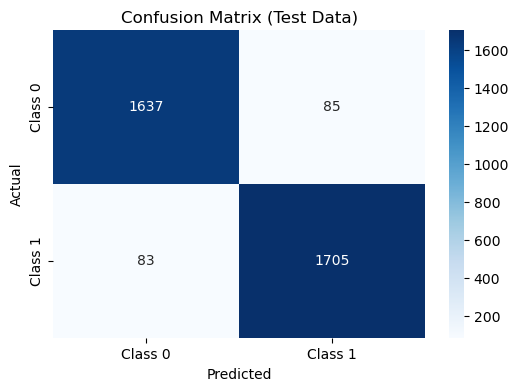

In [15]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9521367521367521
Precision: 0.9535274356103024
Recall: 0.9524608501118568
F1 Score: 0.952993844432009

=== Training Metrics ===
Accuracy: 0.9509154377716036
Precision: 0.9498529205771117
Recall: 0.953458942632171
F1 Score: 0.9516525156129394

X_train shape: (14037, 30)


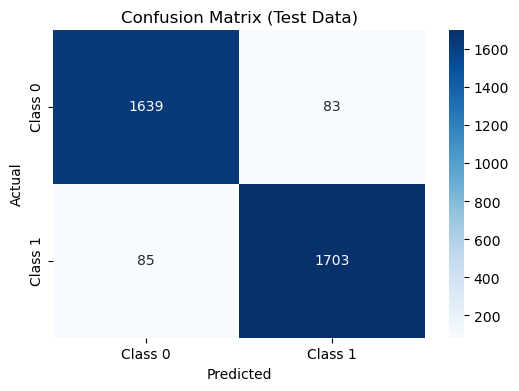

In [16]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

C:\Users\zach allarey\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== Test Metrics ===
Accuracy: 0.9452991452991453
Precision: 0.9473094170403588
Recall: 0.9451901565995525
F1 Score: 0.9462486002239642

=== Training Metrics ===
Accuracy: 0.9436489278335827
Precision: 0.9425850721187509
Recall: 0.9464285714285714
F1 Score: 0.944502911667719

X_train shape: (14037, 30)


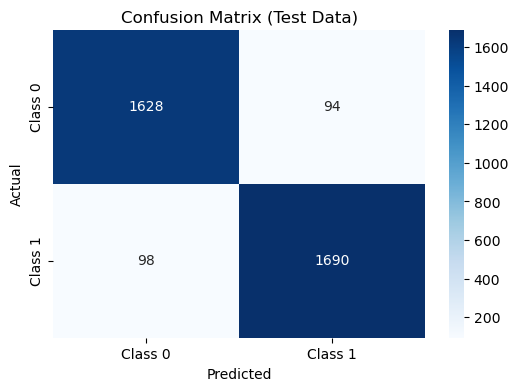

In [17]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [18]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9530
Removed 'p1_ht' → new F1 = 0.9533
Removed 'p2_rank_points' → new F1 = 0.9530
Removed 'surface' → new F1 = 0.9530
→ Stopping: dropping 'p1_rank_points' drops F1 from 0.9530 to 0.9528

Total removed: 4 features
Features removed (in order):
 - p1_ht
 - p2_rank_points
 - surface
 - p1_rank_points


## DecisionTreeClassifier

=== Test Metrics ===
Accuracy: 0.7860398860398861
Precision: 0.7795148247978436
Recall: 0.8087248322147651
F1 Score: 0.7938512215207246

=== Training Metrics ===
Accuracy: 0.7985324499536938
Precision: 0.7872083668543846
Recall: 0.8255061867266592
F1 Score: 0.8059025394646534

X_train shape: (14037, 30)


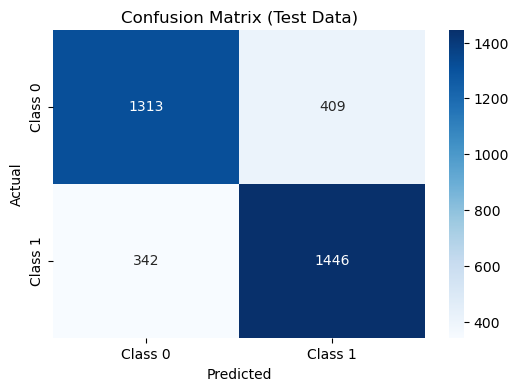

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.7948717948717948
Precision: 0.8101045296167247
Recall: 0.7802013422818792
F1 Score: 0.7948717948717948

=== Training Metrics ===
Accuracy: 0.8162712830376861
Precision: 0.8250394378316364
Recall: 0.8089145106861643
F1 Score: 0.8168974085906994

X_train shape: (14037, 30)


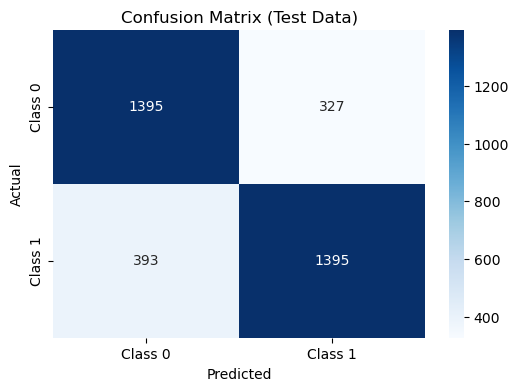

In [20]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

C:\Users\zach allarey\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== Test Metrics ===
Accuracy: 0.9014245014245015
Precision: 0.9068848758465011
Recall: 0.8987695749440716
F1 Score: 0.9028089887640449

=== Training Metrics ===
Accuracy: 0.99964379853245
Precision: 1.0
Recall: 0.9992969628796401
F1 Score: 0.9996483578310711

X_train shape: (14037, 30)


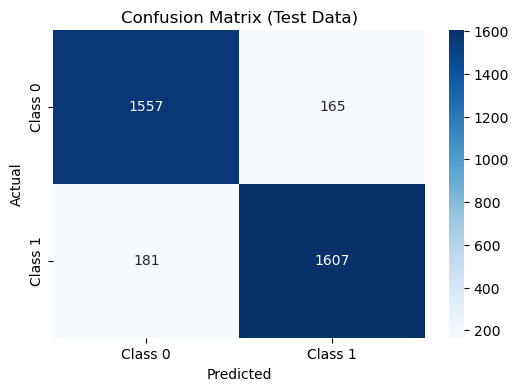

In [21]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [22]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.7939
Removed 'surface' → new F1 = 0.7939
Removed 'p1_hand' → new F1 = 0.7939
Removed 'p1_ht' → new F1 = 0.7939
Removed 'p1_age' → new F1 = 0.7939
Removed 'p2_hand' → new F1 = 0.7939
Removed 'p2_ht' → new F1 = 0.7939
Removed 'p2_age' → new F1 = 0.7939
Removed 'minutes' → new F1 = 0.7939
Removed 'p1_ace' → new F1 = 0.7939
Removed 'p1_df' → new F1 = 0.7939
Removed 'p1_svpt' → new F1 = 0.7939
Removed 'p1_1stIn' → new F1 = 0.7939
Removed 'p2_1stIn' → new F1 = 0.7939
Removed 'p2_rank_points' → new F1 = 0.7939
Removed 'p1_2ndWon' → new F1 = 0.7939
Removed 'p1_SvGms' → new F1 = 0.7939
Removed 'p2_ace' → new F1 = 0.7939
Removed 'p2_df' → new F1 = 0.7939
Removed 'p2_svpt' → new F1 = 0.7939
Removed 'p2_2ndWon' → new F1 = 0.7939
Removed 'p2_SvGms' → new F1 = 0.7939
Removed 'p2_bpSaved' → new F1 = 0.7939
Removed 'p1_rank' → new F1 = 0.7939
Removed 'p1_rank_points' → new F1 = 0.7939
Removed 'p2_rank' → new F1 = 0.7939
Removed 'p2_1stWon' → new F1 = 0.7939
Removed 'p1_1stWon' → new F1 

## Random Forest

=== Test Metrics ===
Accuracy: 0.8572649572649572
Precision: 0.8629441624365483
Recall: 0.8557046979865772
F1 Score: 0.8593091828138163

=== Training Metrics ===
Accuracy: 0.9312531167628411
Precision: 0.9282429984673262
Recall: 0.936726659167604
F1 Score: 0.9324655329274267

X_train shape: (14037, 30)


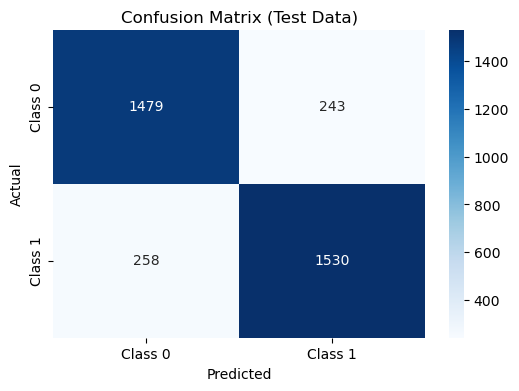

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.856980056980057
Precision: 0.868270332187858
Recall: 0.8478747203579419
F1 Score: 0.8579513299377476

=== Training Metrics ===
Accuracy: 0.9250552112274703
Precision: 0.9242509101092131
Recall: 0.9281496062992126
F1 Score: 0.9261961554651326

X_train shape: (14037, 30)


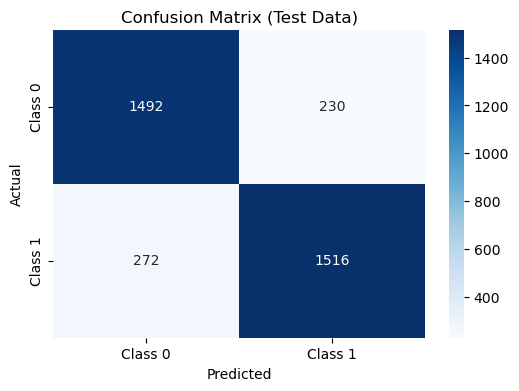

In [24]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

C:\Users\zach allarey\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== Test Metrics ===
Accuracy: 0.913960113960114
Precision: 0.9216799091940976
Recall: 0.9082774049217002
F1 Score: 0.9149295774647888

=== Training Metrics ===
Accuracy: 0.99992875970649
Precision: 1.0
Recall: 0.999859392575928
F1 Score: 0.9999296913450045

X_train shape: (14037, 30)


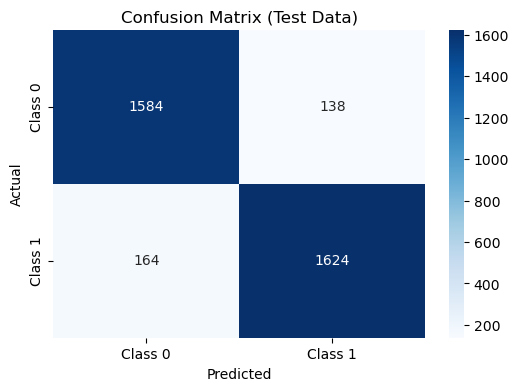

In [25]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [26]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")

Baseline F1: 0.8593
→ Stopping: dropping 'p1_hand' drops F1 from 0.8593 to 0.8584

Total removed: 1 features
Features removed (in order):
 - p1_hand


## KNN

=== Test Metrics ===
Accuracy: 0.8236467236467236
Precision: 0.8292957746478873
Recall: 0.8232662192393736
F1 Score: 0.8262699971933763

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


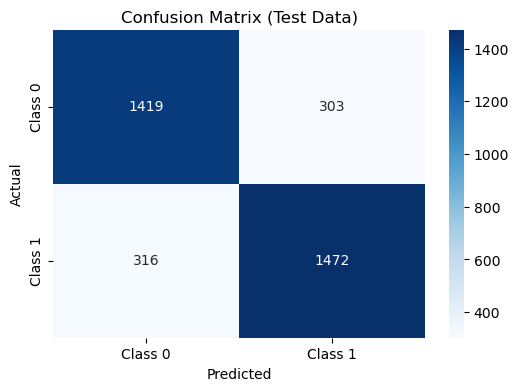

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.856980056980057
Precision: 0.868270332187858
Recall: 0.8478747203579419
F1 Score: 0.8579513299377476

=== Training Metrics ===
Accuracy: 0.9250552112274703
Precision: 0.9242509101092131
Recall: 0.9281496062992126
F1 Score: 0.9261961554651326

X_train shape: (14037, 30)


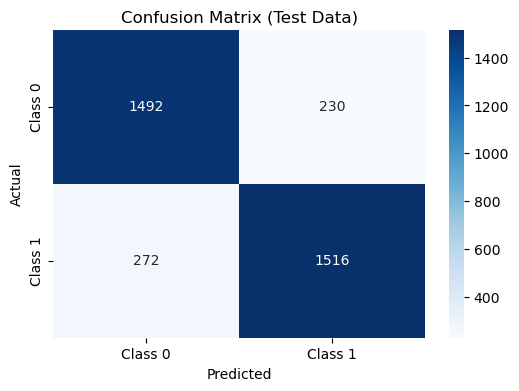

In [28]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

C:\Users\zach allarey\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== Test Metrics ===
Accuracy: 0.913960113960114
Precision: 0.9216799091940976
Recall: 0.9082774049217002
F1 Score: 0.9149295774647888

=== Training Metrics ===
Accuracy: 0.99992875970649
Precision: 1.0
Recall: 0.999859392575928
F1 Score: 0.9999296913450045

X_train shape: (14037, 30)


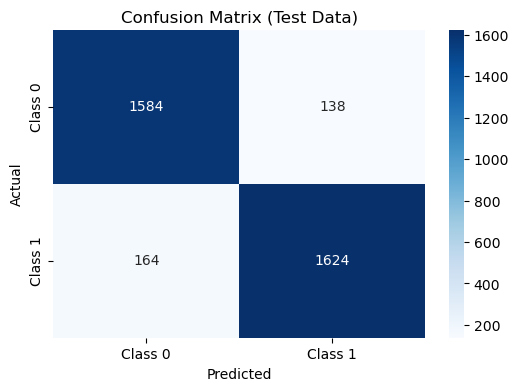

In [29]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [30]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.8593
→ Stopping: dropping 'p1_hand' drops F1 from 0.8593 to 0.8584

Total removed: 1 features
Features removed (in order):
 - p1_hand


## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9521367521367521
Precision: 0.9530201342281879
Recall: 0.9530201342281879
F1 Score: 0.9530201342281879

=== Training Metrics ===
Accuracy: 0.9514853601196837
Precision: 0.950539442342721
Recall: 0.953880764904387
F1 Score: 0.9522071724331532

X_train shape: (14037, 30)


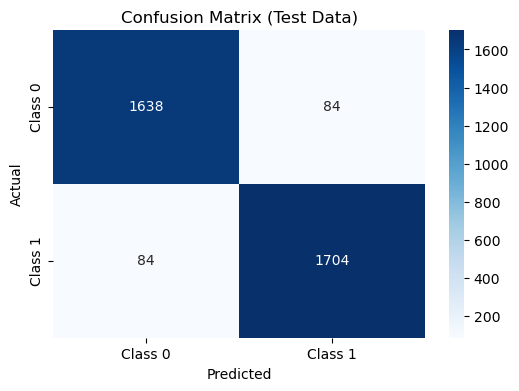

In [31]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9524216524216524
Precision: 0.95406162464986
Recall: 0.9524608501118568
F1 Score: 0.9532605653512455

=== Training Metrics ===
Accuracy: 0.9510579183586236
Precision: 0.9501190976600813
Recall: 0.953458942632171
F1 Score: 0.9517860902519475

X_train shape: (14037, 30)


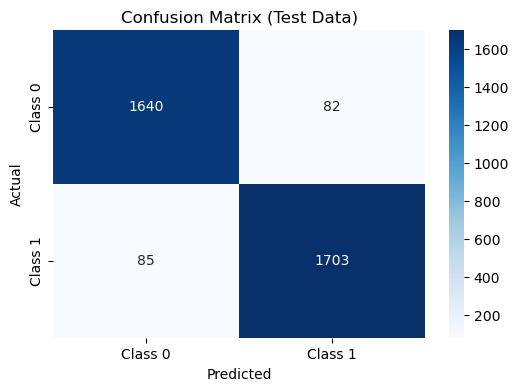

In [32]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

In [46]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

C:\Users\zach allarey\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

## Wrapper Method

In [ ]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

## SVM Gaussian Kernel

In [ ]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

In [ ]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Logistic & KNN -> Decision Tree

In [ ]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Gaussian SVC & Decision Tree -> Logistic

In [ ]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Visualizing the Dataset

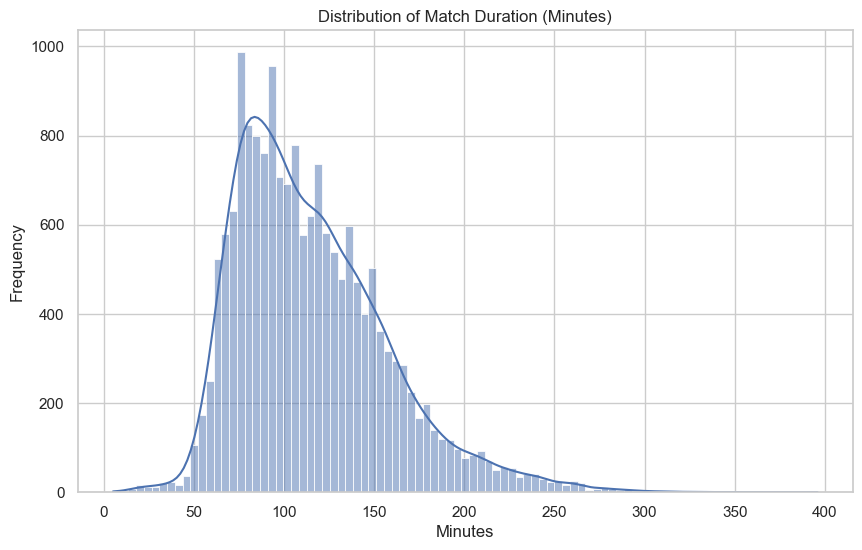

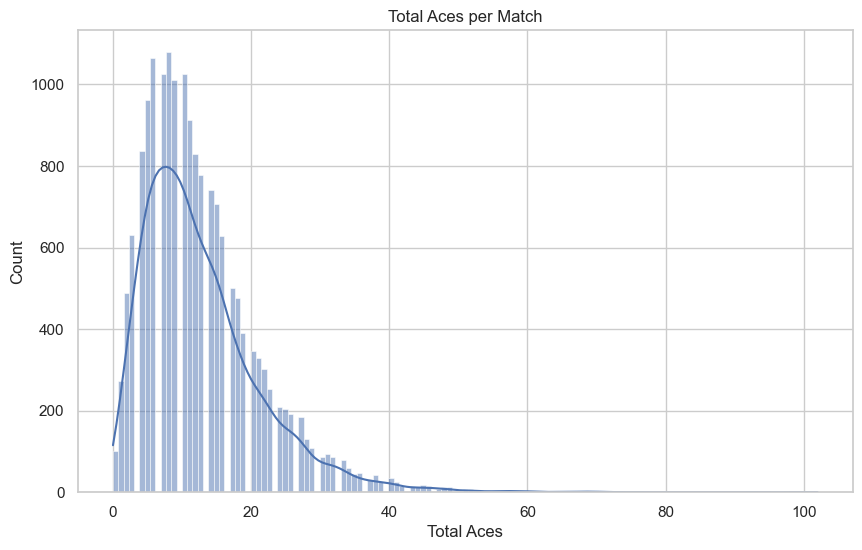

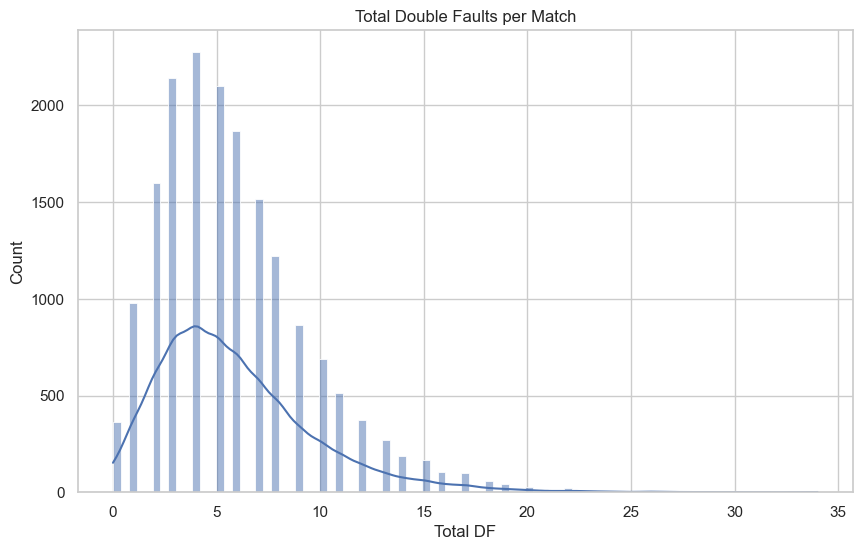

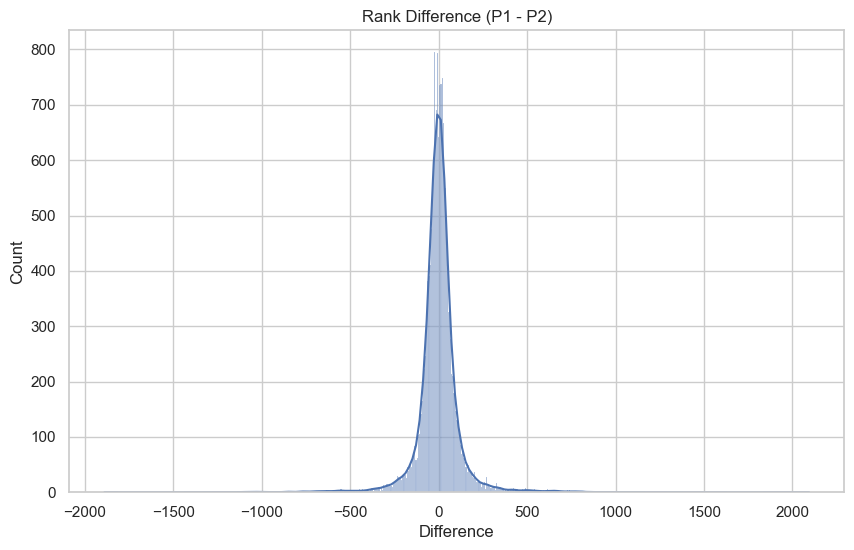

In [87]:
#visualizing the dataset under 4 main categories covering 20 plots
#match overview, serving stats, player attributes, and outcome insights
#these 4 are the general basis but the plots after the first 20 cover more stuff and other variables too
#----------match overview----------
#plot 1: Match Distribution
#shows how long the matches typically last with a peak around 90-120 minutes
#there are outliters that suggest long 3-set matches
sns.histplot(df['minutes'], kde=True)
plt.title("Distribution of Match Duration (Minutes)")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

#plot 2: Total Aces Per Match
#displays the service dominance!!!
#a high total may suggest an aggressive play style due to high aces
sns.histplot(df['p1_ace'] + df['p2_ace'], kde=True)
plt.title("Total Aces per Match")
plt.xlabel("Total Aces")
plt.show()

#plot 3: Double Faults Per Match
#reveals how often that the players lose points because of their poor serves
#these double faults can correlate with nerves / poor second serve
sns.histplot(df['p1_df'] + df['p2_df'], kde=True)
plt.title("Total Double Faults per Match")
plt.xlabel("Total DF")
plt.show()

#plot 4: Rank Difference
#this rank difference shows how big of a MISMATCH there is
#a large positive or negative can predict ONE-SIDED matches
df['rank_diff'] = df['p1_rank'] - df['p2_rank']
sns.histplot(df['rank_diff'], kde=True)
plt.title("Rank Difference (P1 - P2)")
plt.xlabel("Difference")
plt.show()


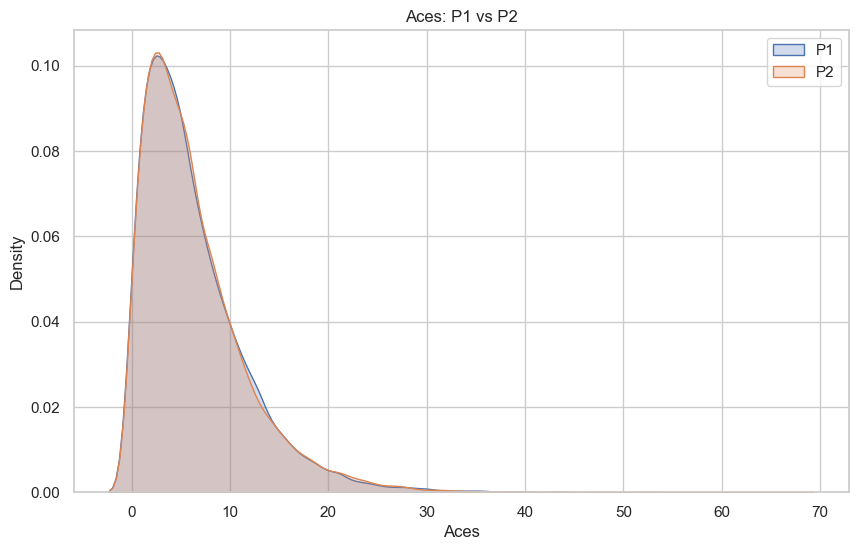

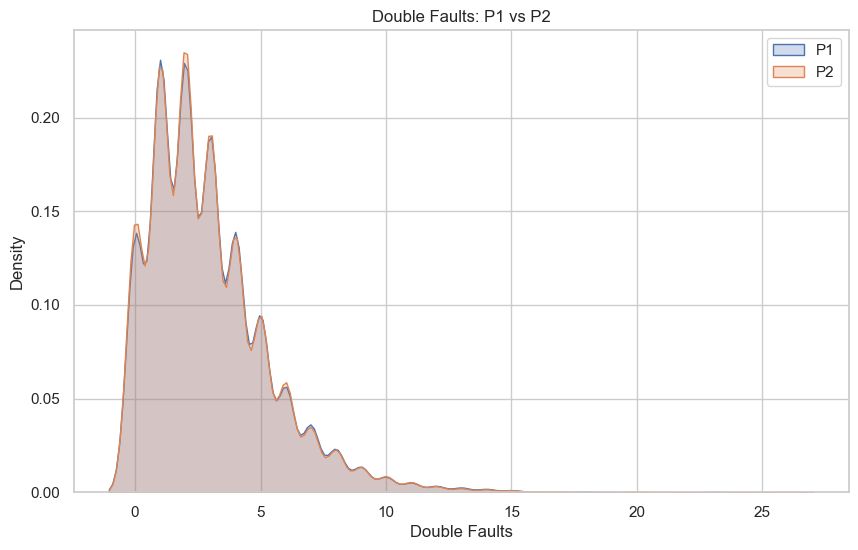

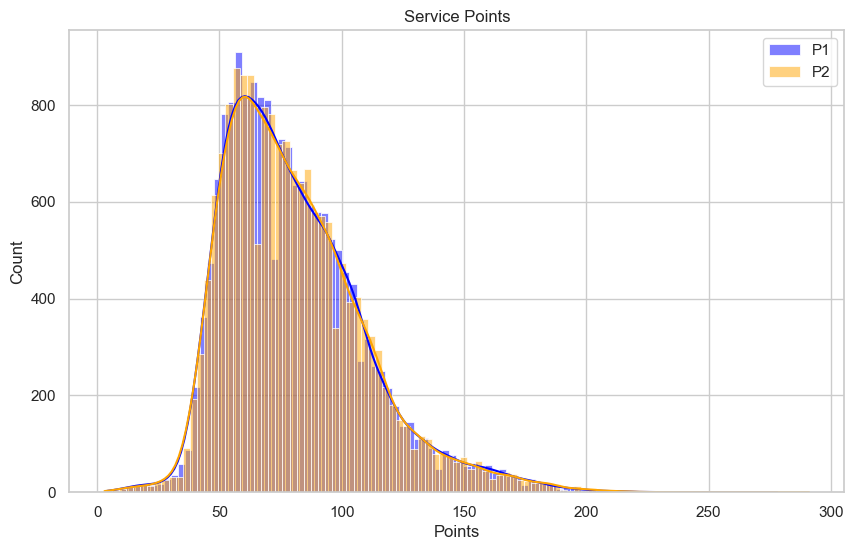

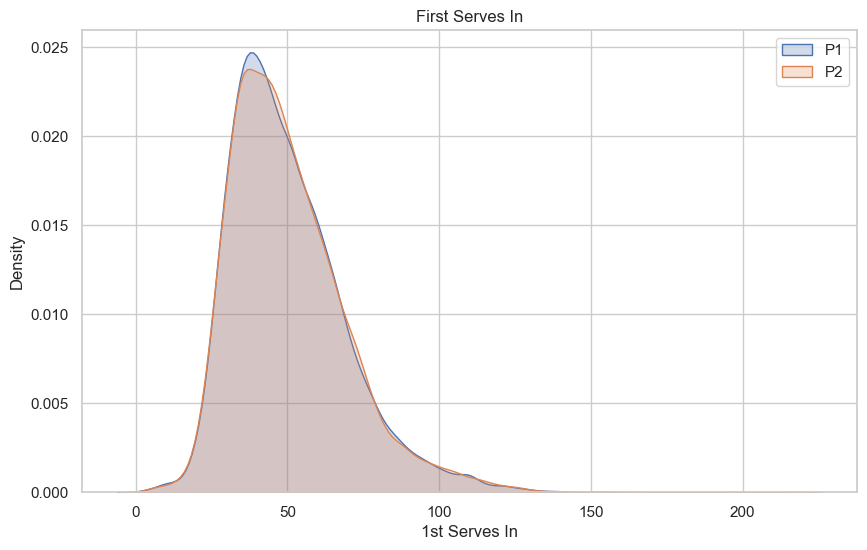

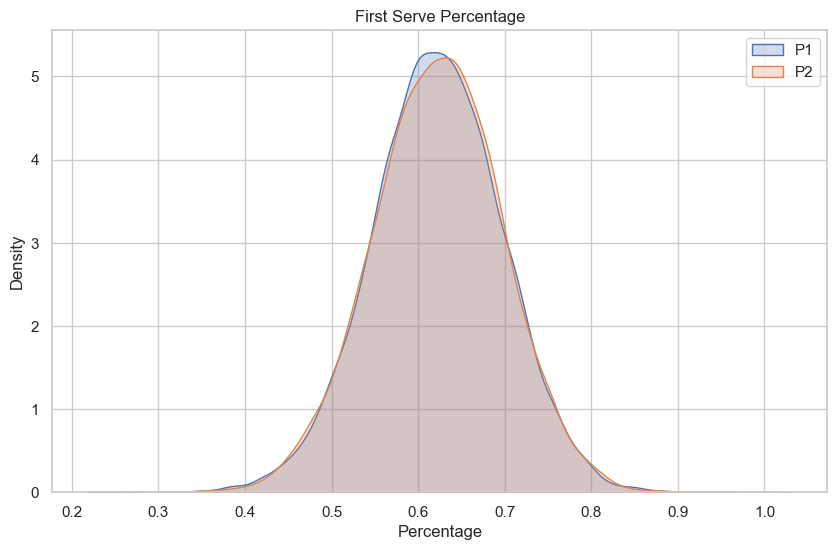

In [88]:
#----------serving stats----------
#plot 5: aces: P1 vs P2
#shows the serve FIREPOWER
#reveals if either side is consistent or makes more unreturnable (ace) serves
sns.kdeplot(df['p1_ace'], label='P1', fill=True)
sns.kdeplot(df['p2_ace'], label='P2', fill=True)
plt.title("Aces: P1 vs P2")
plt.xlabel("Aces")
plt.legend()
plt.show()

#plot 6:Double Faults: P1 vs P2
#this plot highlights error rates for players
sns.kdeplot(df['p1_df'], label='P1', fill=True)
sns.kdeplot(df['p2_df'], label='P2', fill=True)
plt.title("Double Faults: P1 vs P2")
plt.xlabel("Double Faults")
plt.legend()
plt.show()

#plot 7: Service Points: P1 vs P2
#total serve points per player
sns.histplot(df['p1_svpt'], color="blue", label="P1", kde=True)
sns.histplot(df['p2_svpt'], color="orange", label="P2", kde=True)
plt.title("Service Points")
plt.xlabel("Points")
plt.legend()
plt.show()

#Plot 8: First Serves In: P1 vs P2
#the raw first servce counts
#the higher numbers indicate consistency or even longer matches
sns.kdeplot(df['p1_1stIn'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'], label='P2', fill=True)
plt.title("First Serves In")
plt.xlabel("1st Serves In")
plt.legend()
plt.show()

#plot 9: First Serve %: P1 vs P2
#serve reliability
#a higher first serve % generally leads to a better win probability
sns.kdeplot(df['p1_1stIn'] / df['p1_svpt'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'] / df['p2_svpt'], label='P2', fill=True)
plt.title("First Serve Percentage")
plt.xlabel("Percentage")
plt.legend()
plt.show()

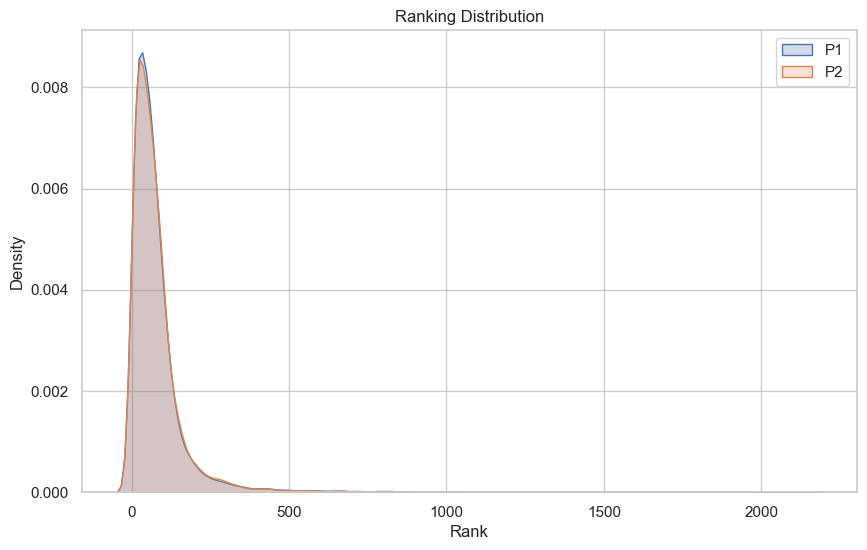

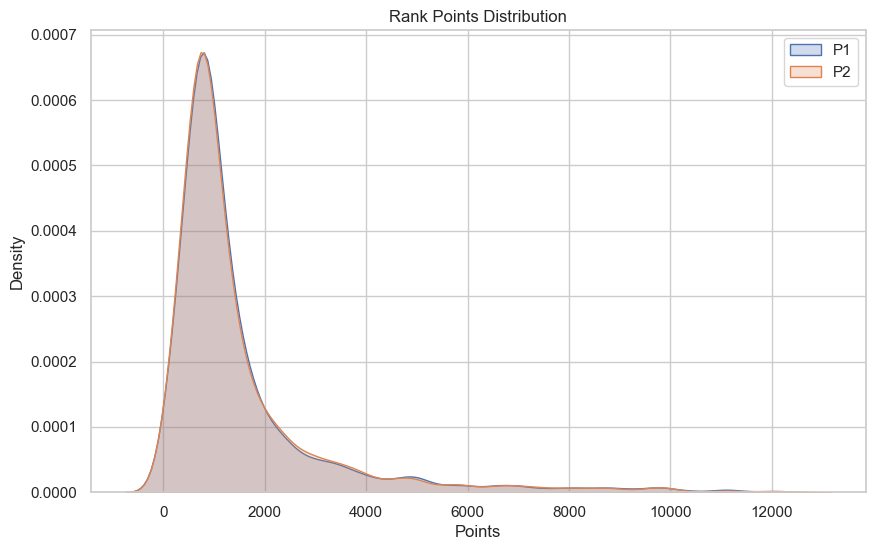

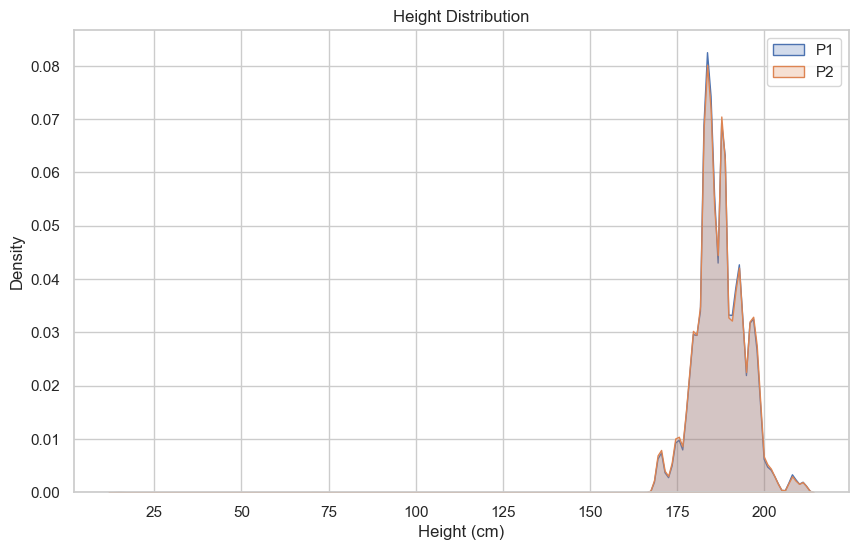

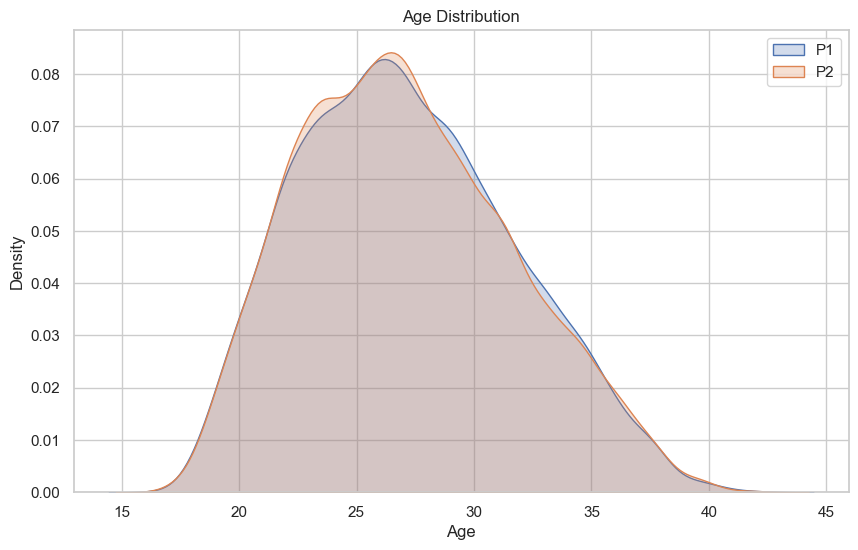

In [89]:
#----------player attributes---------
#plot 10: Ranking: P1 vs P2
#overall player levels
#the concentrated ranges show that most players are in the top 200
sns.kdeplot(df['p1_rank'], label='P1', fill=True)
sns.kdeplot(df['p2_rank'], label='P2', fill=True)
plt.title("Ranking Distribution")
plt.xlabel("Rank")
plt.legend()
plt.show()

#plot 11: Rank Points: P1 vs P2
#shows performance consistency across the season
sns.kdeplot(df['p1_rank_points'], label='P1', fill=True)
sns.kdeplot(df['p2_rank_points'], label='P2', fill=True)
plt.title("Rank Points Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

#plot 12: Height: P1 vs P2
#does height affect serve, reach, or even court advantage??
sns.kdeplot(df['p1_ht'], label='P1', fill=True)
sns.kdeplot(df['p2_ht'], label='P2', fill=True)
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.legend()
plt.show()

#plot 13: Age: P1 vs P2
#Age. younger players show stamina while the older may show experience
sns.kdeplot(df['p1_age'], label='P1', fill=True)
sns.kdeplot(df['p2_age'], label='P2', fill=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.legend()
plt.show()


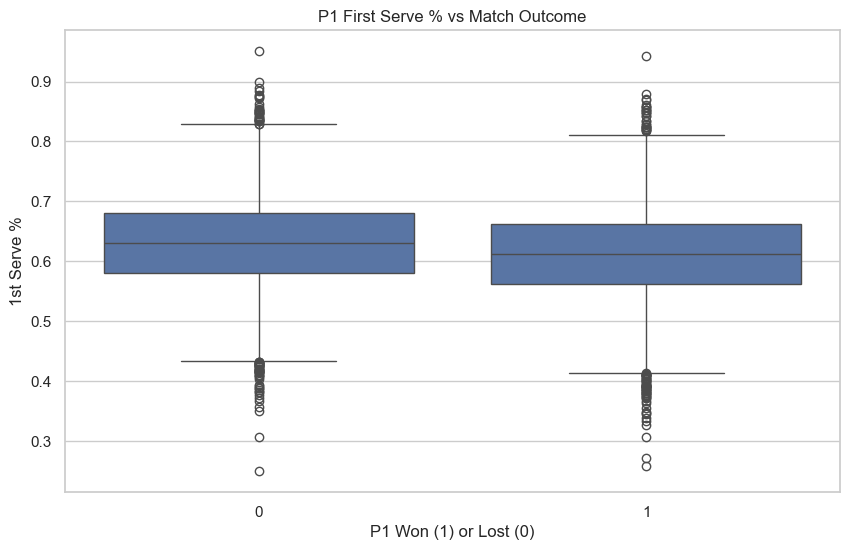

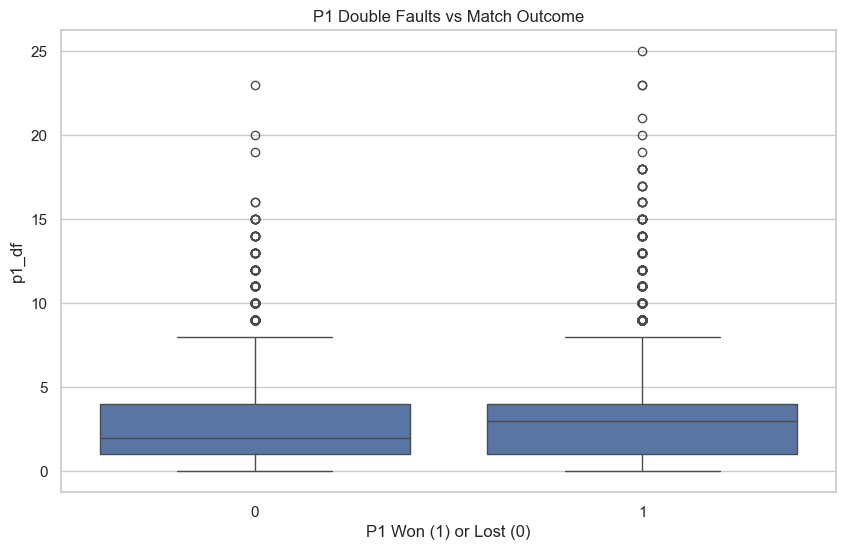

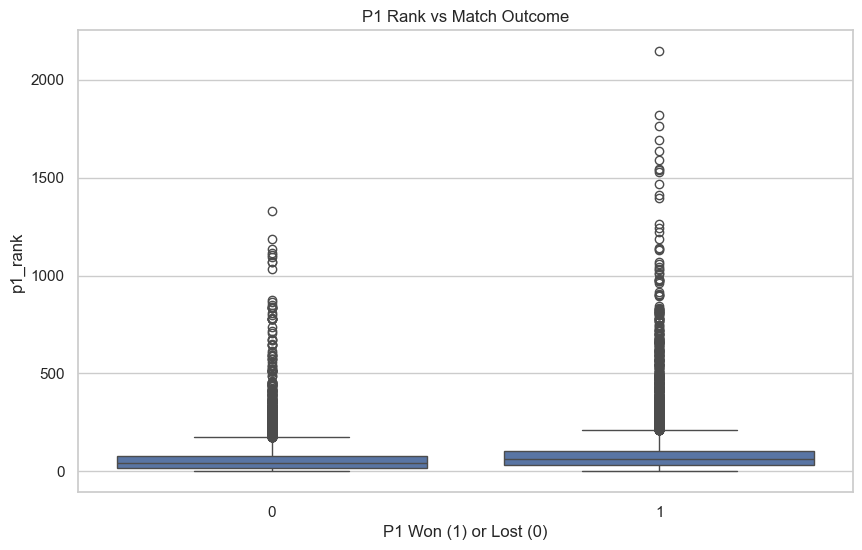

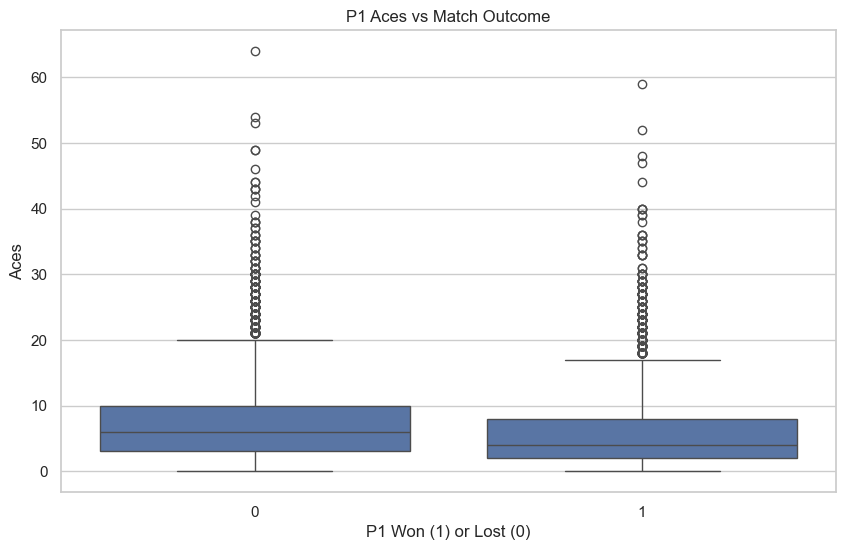

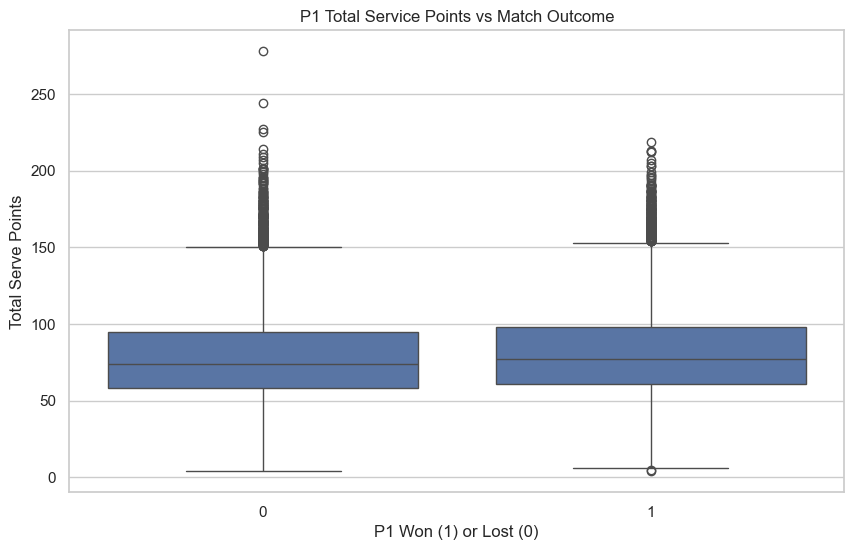

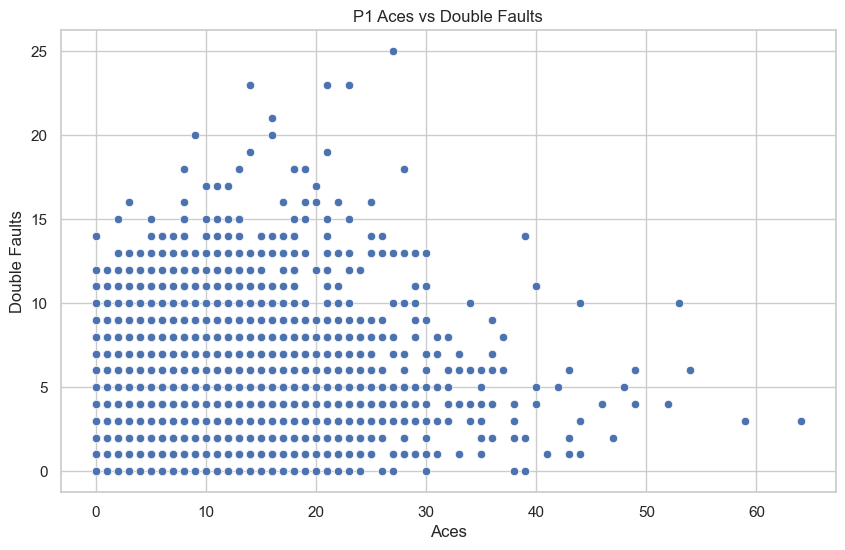

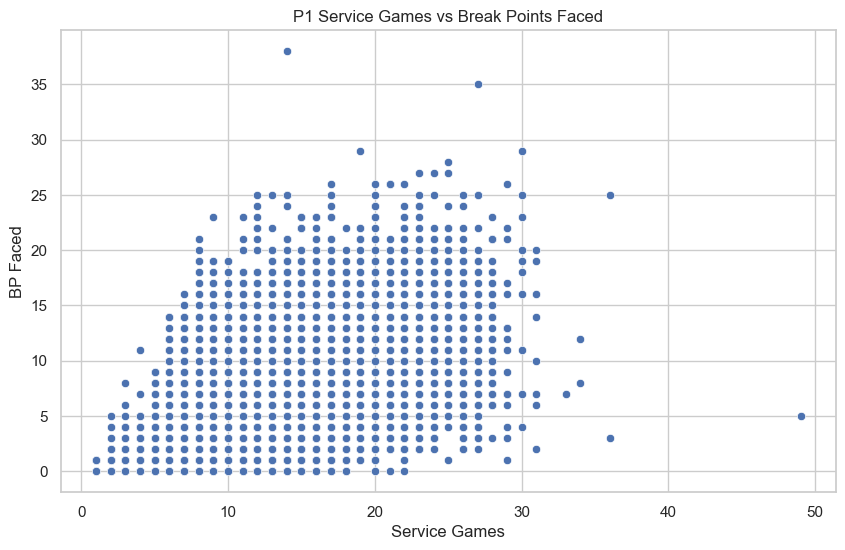

In [90]:
#----------outcomine insights----------
#plot 14: First Serve % vs Win
#a higher first serve % often leads to wins where as a low % can result in more second serve pressure
sns.boxplot(x='winner', y=df['p1_1stIn'] / df['p1_svpt'], data=df)
plt.title("P1 First Serve % vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("1st Serve %")
plt.show()

#plot 15: Double Faults vs Win
#a higher DF count correlates with losses, ESPECIALLY in close matches
sns.boxplot(x='winner', y='p1_df', data=df)
plt.title("P1 Double Faults vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 16: Rank vs Win
#winners are often in the higher ranks but this shows if there are the UNDERDOGS 
sns.boxplot(x='winner', y='p1_rank', data=df)
plt.title("P1 Rank vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 17: Aces vs Win (P1)
#aces dont GUARANTEE a win but aces are generally corresponded to wins
sns.boxplot(x='winner', y='p1_ace', data=df)
plt.title("P1 Aces vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Aces")
plt.show()

#plot 18: Total Service Points vs Win (P1)
#how total points relate to the match outcome
sns.boxplot(x='winner', y='p1_svpt', data=df)
plt.title("P1 Total Service Points vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Total Serve Points")
plt.show()

#plot 19: Aces vs Double Faults (P1)
#shows serve styles
#whether they are aggressive (high ace and high df)
#passive (low df, low ace)
sns.scatterplot(x='p1_ace', y='p1_df', data=df)
plt.title("P1 Aces vs Double Faults")
plt.xlabel("Aces")
plt.ylabel("Double Faults")
plt.show()

#plot 20: Service Games vs BPs Faced (P1)
#measures the serve stability
sns.scatterplot(x='p1_SvGms', y='p1_bpFaced', data=df)
plt.title("P1 Service Games vs Break Points Faced")
plt.xlabel("Service Games")
plt.ylabel("BP Faced")
plt.show()

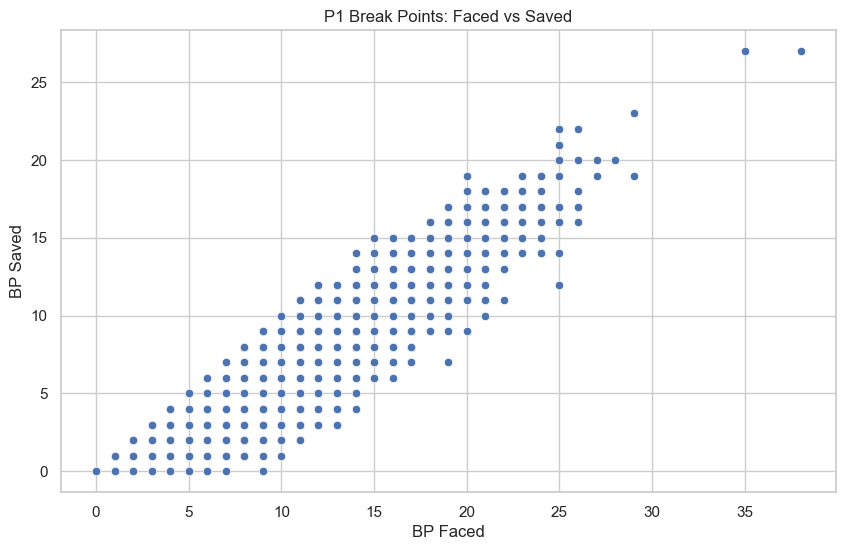

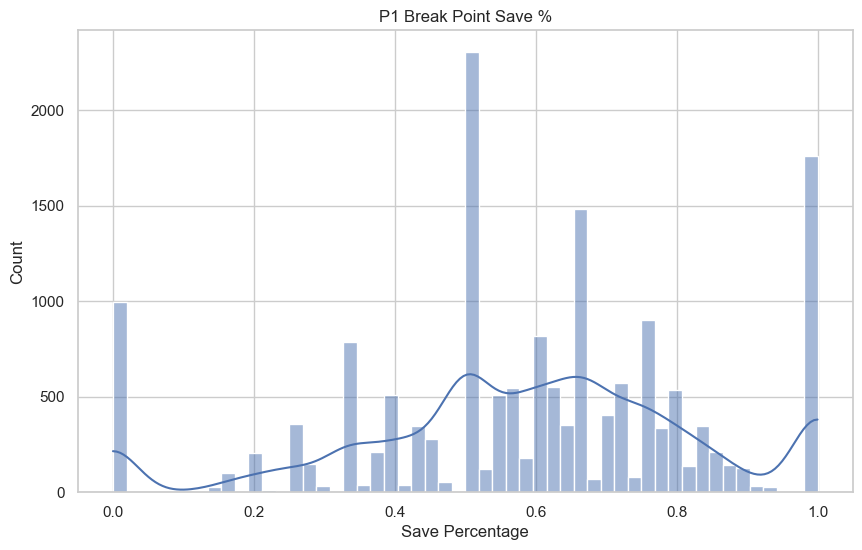

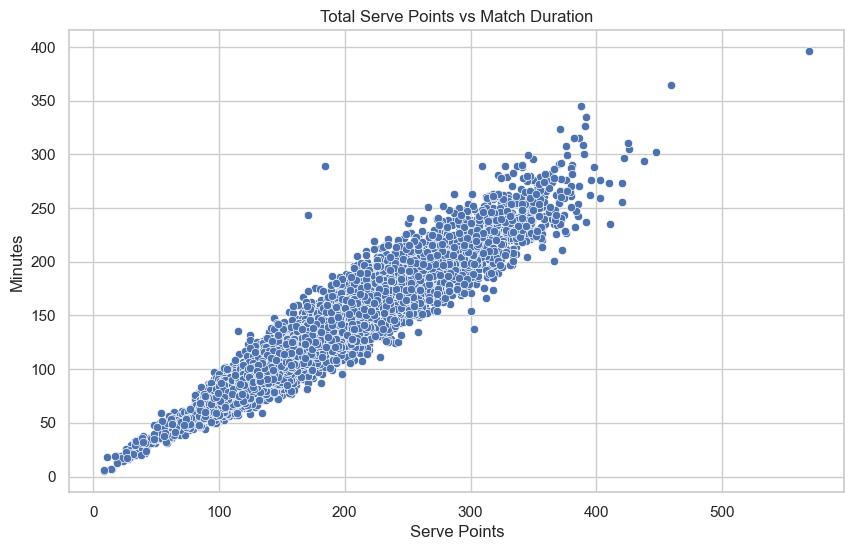

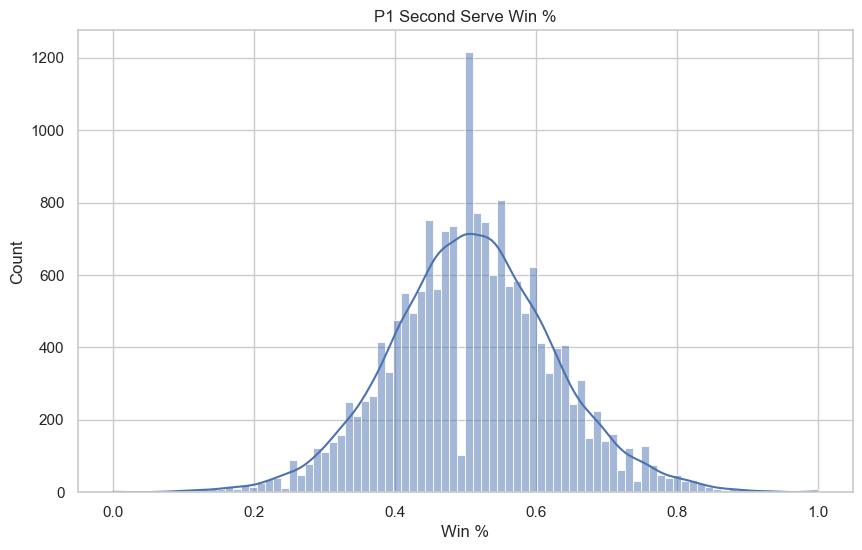

In [91]:
#----------CLUTCH GENE----------
#plot 21:Break Points Faced vs Saved (P1)
sns.scatterplot(x='p1_bpFaced', y='p1_bpSaved', data=df)
plt.title("P1 Break Points: Faced vs Saved")
plt.xlabel("BP Faced")
plt.ylabel("BP Saved")
plt.show()

#plot 22: Break Point Save Percentage
df['p1_bpPct'] = df['p1_bpSaved'] / df['p1_bpFaced']
sns.histplot(df['p1_bpPct'], kde=True)
plt.title("P1 Break Point Save %")
plt.xlabel("Save Percentage")
plt.show()

#----------stamina and match duration----------
#plot 23: Total Serve Points vs Match Duration
df['total_svpt'] = df['p1_svpt'] + df['p2_svpt']
sns.scatterplot(x='total_svpt', y='minutes', data=df)
plt.title("Total Serve Points vs Match Duration")
plt.xlabel("Serve Points")
plt.ylabel("Minutes")
plt.show()

#----------second serve stats----------
#plot 24: Second Serve Win %
df['p1_2ndPct'] = df['p1_2ndWon'] / (df['p1_svpt'] - df['p1_1stIn'])
sns.histplot(df['p1_2ndPct'], kde=True)
plt.title("P1 Second Serve Win %")
plt.xlabel("Win %")
plt.show()

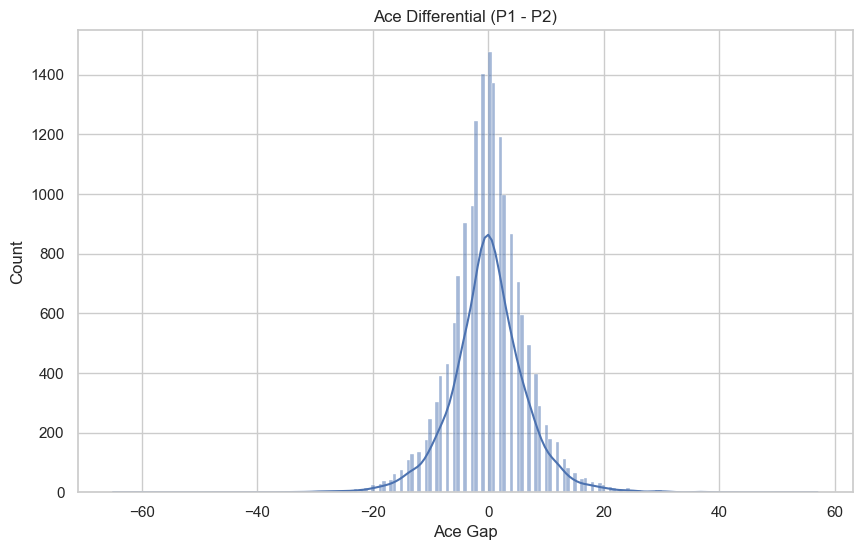

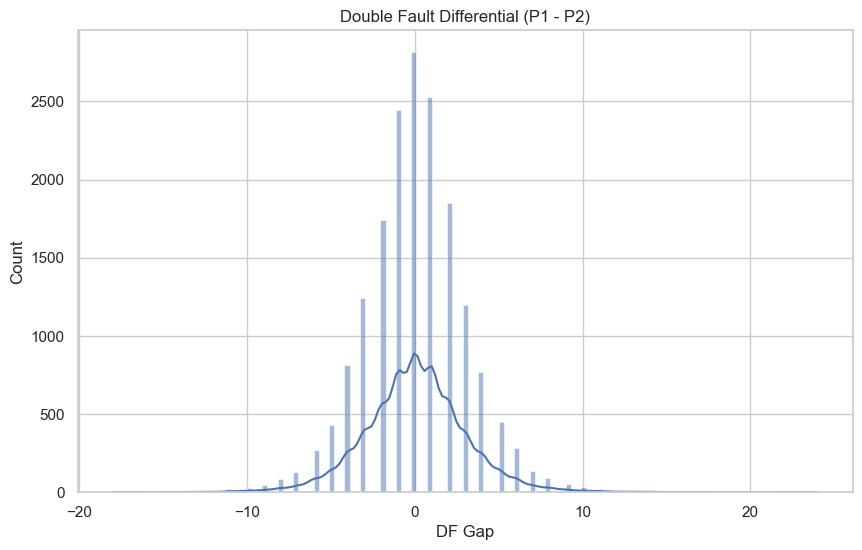

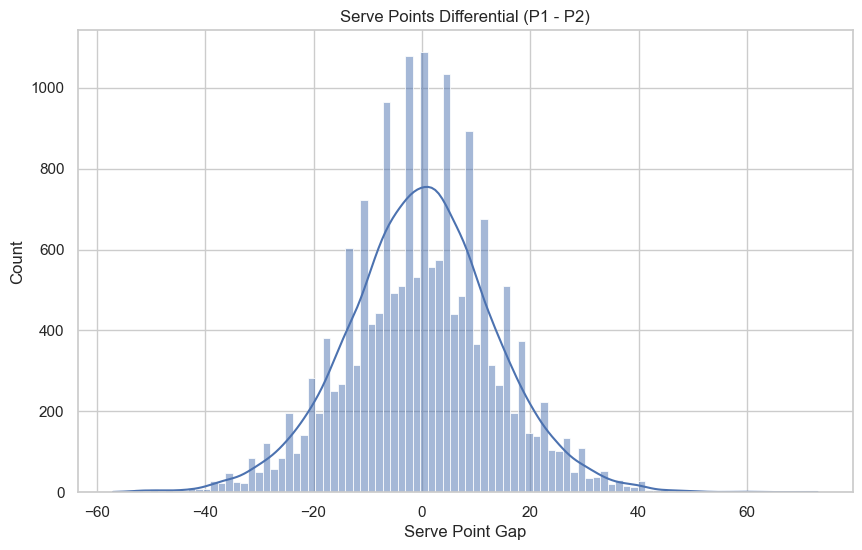

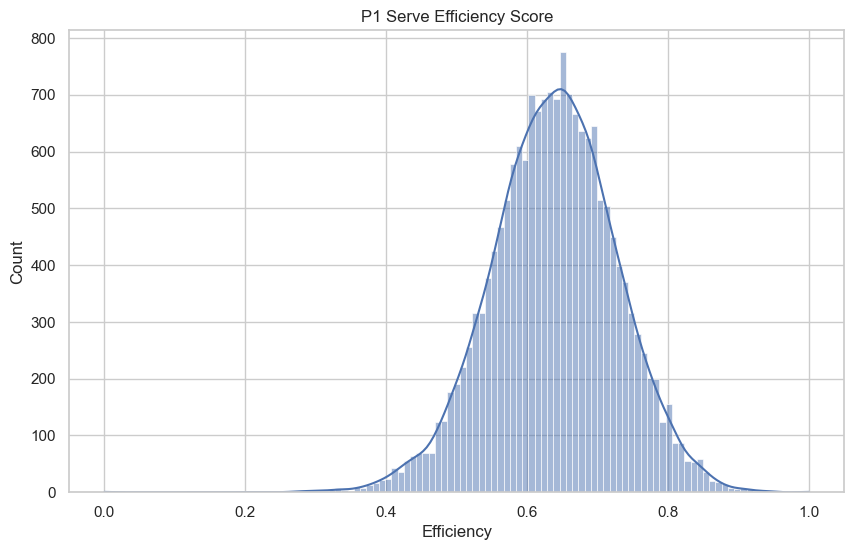

In [86]:
#----------HEAD-TO-HEAD----------
#plot 25: Ace Differential
df['ace_gap'] = df['p1_ace'] - df['p2_ace']
sns.histplot(df['ace_gap'], kde=True)
plt.title("Ace Differential (P1 - P2)")
plt.xlabel("Ace Gap")
plt.show()

#plot 26: Double Fault Differential 
df['df_gap'] = df['p1_df'] - df['p2_df']
sns.histplot(df['df_gap'], kde=True)
plt.title("Double Fault Differential (P1 - P2)")
plt.xlabel("DF Gap")
plt.show()

#plot 27: Serve Points Differential
df['svpt_gap'] = df['p1_svpt'] - df['p2_svpt']
sns.histplot(df['svpt_gap'], kde=True)
plt.title("Serve Points Differential (P1 - P2)")
plt.xlabel("Serve Point Gap")
plt.show()

#plot 28: Serve Efficiency Score (P1)
df['p1_efficiency'] = (df['p1_1stWon'] + df['p1_2ndWon']) / df['p1_svpt']
sns.histplot(df['p1_efficiency'], kde=True)
plt.title("P1 Serve Efficiency Score")
plt.xlabel("Efficiency")
plt.show()

## KNN With HyperTuning

In [24]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# import pandas as pd

# param_grid = {
#     "n_neighbors": [100, 200],
#     "weights":     ["uniform", "distance"],
#     "metric":      ["euclidean", "manhattan"],
#     "algorithm":   ["auto", "kd_tree", "ball_tree"]
# }

# grid_knn = GridSearchCV(
#     estimator   = KNeighborsClassifier(),
#     param_grid  = param_grid,
#     scoring     = "balanced_accuracy",
#     verbose     = 0
# )

# grid_knn.fit(X_train, y_train)

# print("Best hyper‑parameters:", grid_knn.best_params_)
# print(f"Best score (train only): {grid_knn.best_score_:.4f}")

# best_knn      = grid_knn.best_estimator_
# y_pred_test   = best_knn.predict(X_test)
# y_pred_train  = best_knn.predict(X_train)

# # Custom evaluation
# evaluate_model(y_pred_test, y_pred_train)

# results = pd.DataFrame(grid_knn.cv_results_)
# top5 = results.sort_values(by="mean_test_score", ascending=False).head()

# print("Top 5 configs:")
# print(top5[["params", "mean_test_score"]])

## DecisionTreeClassifier with Hypertuning

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# dt_manual = DecisionTreeClassifier(
#     criterion="entropy",
#     max_depth=10,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     class_weight="balanced",
#     random_state=42
# )
# dt_manual.fit(X_train, y_train)

# y_pred_test  = dt_manual.predict(X_test)
# y_pred_train = dt_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)

## Logistic Regression With Hypertuning

In [ ]:
# # Tried on this one but not much change, running gridsearch on all will blow up our computers

# # testing elastic 
# from sklearn.linear_model import LogisticRegression

# log_manual = LogisticRegression(
#     penalty="elasticnet",
#     C=1.0,
#     l1_ratio=0.5,
#     class_weight="balanced",
#     solver="saga",
#     max_iter=10000,
#     random_state=42
# )
# log_manual.fit(X_train, y_train)

# y_pred_test  = log_manual.predict(X_test)
# y_pred_train = log_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)